# Fashion MNIST Classification
---
Fashion-MNIST is a dataset of Zalando's article images—consisting of a **training set of 60,000** examples and a **test set of 10,000 examples**. Each example is a **28x28 grayscale** image, associated with a label from **10 classes**. We intend Fashion-MNIST to serve as a direct drop-in **replacement for the original MNIST** dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

Here's an example how the data looks (each class takes three-rows):
![Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist/raw/master/doc/img/fashion-mnist-sprite.png)

### Step # 1 - Import Libraries
---
Lets import all the libraries we are going to require for this classification project. It is always good to put all the import statements at the begining of the file.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
from keras.utils import to_categorical

Using TensorFlow backend.


### Step # 2 - Load Data
---
Now lets use **pandas** library to read the train and test datasets in the respective csv files. We are going to use the **read_csv** function which reads a csv file and returns a pandas **DataFrame** object.

In [2]:
fashion_train_df = pd.read_csv('../input/fashion-mnist-datasets/fashion-mnist_train.csv', sep=',')
fashion_test_df = pd.read_csv('../input/fashion-mnist-datasets/fashion-mnist_test.csv', sep=',')

Now that we have loaded the datasets, lets check some parameters about the datasets.

In [3]:
fashion_train_df.shape   # Shape of the dataset

(60000, 785)

In [4]:
fashion_train_df.columns   # Name of the columns of the DataSet.

Index(['label', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779', 'pixel780',
       'pixel781', 'pixel782', 'pixel783', 'pixel784'],
      dtype='object', length=785)

So we can see that the 1st column is the label or target value for each row.

Now Lets find out how many distinct lables we have.

In [5]:
print(set(fashion_train_df['label']))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


So we have 10 different lables. from 0 to 9. 

Now lets find out what is the min and max of values of in the other columns.

In [6]:
print([fashion_train_df.drop(labels='label', axis=1).min(axis=1).min(), 
      fashion_train_df.drop(labels='label', axis=1).max(axis=1).max()])

[0, 255]


So we have 0 to 255 which is the color values for grayscale. 0 being white and 255 being black.

Now lets check some of the rows in tabular format

In [7]:
fashion_train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,0,0,105,92,101,107,100,132,0,0,2,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150,...,211,220,214,74,0,255,222,128,0,0,0,0,0,0,0,0,0,44,12,0,0,40,134,162,191,214,163,146,165,79,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,0,114,183,112,55,23,72,102,165,160,28,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,24,188,163,93,...,171,249,207,197,202,45,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,22,21,25,69,52,45,74,39,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,0,0,0,46,0,21,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,187,189,...,230,237,229,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,116,112,136,147,144,121,102,63,0,0,0,0,0,0,0,0,0,0


So evry other things of the test dataset are going to be the same as the train dataset except the shape.

In [8]:
fashion_test_df.shape

(10000, 785)

So here we have 10000 images instead of 60000 as in the train dataset.

Lets check first few rows.

In [9]:
fashion_test_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,0,0,34,29,7,0,11,24,0,0,3,3,1,0,1,1,0,0,0,0,0,4,0,0,1,0,0,0,0,0,...,242,245,224,245,234,0,3,0,0,0,0,0,0,0,0,0,0,0,0,37,69,94,123,127,138,138,142,145,135,125,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,209,190,181,150,170,193,180,219,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,...,248,238,80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,174,233,155,0,65,235,216,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,17,0,0,0,0,0,0,0,0,12,94,68,14,0,0,0,0,0,0,0,0,0,0,0,38,106,94,89,94,68,...,0,0,0,0,0,0,87,12,26,0,0,0,0,0,0,0,46,50,29,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,161,212,138,150,169,164,176,202,255,183,26,0,0,0,0,0,0,0,0,0,0,0,1,0,0,129,221,255,255,215,...,255,255,254,252,255,101,196,254,252,100,0,0,0,0,0,168,232,225,0,41,172,147,148,153,155,146,137,141,143,137,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,0,37,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,204,235,...,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,69,0,2,0,0,0,0,0,0,0,0,0,0


### Step # 3 - Visualization
---
Now that we have loaded the data and also got somewhat acquainted with it lets visualize the actual images. We are going to use **Matplotlib** library for this. 

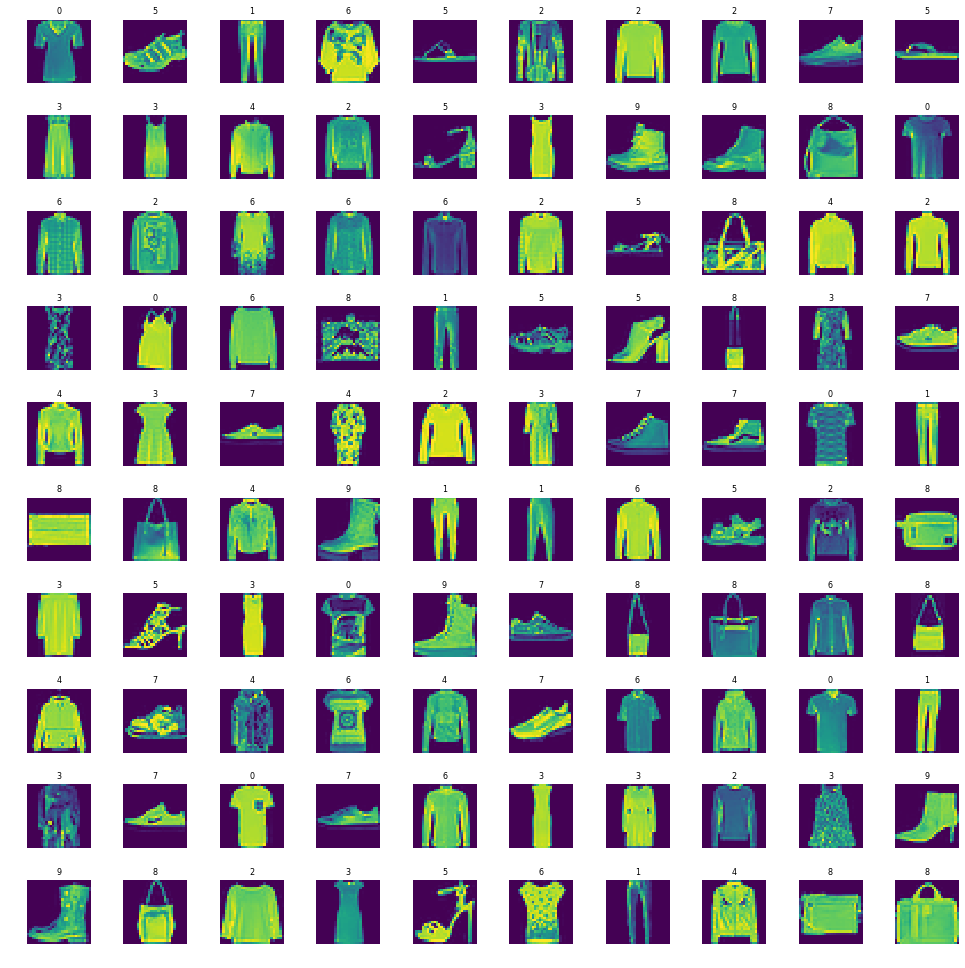

In [10]:
# Convert the dataframe ti numpy array
training = np.asarray(fashion_train_df, dtype='float32')

# Lets show multiple images in a 15x15 grid
height = 10
width = 10

fig, axes = plt.subplots(nrows=width, ncols=height, figsize=(17,17))
axes = axes.ravel()  # this flattens the 15x15 matrix into 225
n_train = len(training)

for i in range(0, height*width):
    index = np.random.randint(0, n_train)
    axes[i].imshow(training[index, 1:].reshape(28,28))
    axes[i].set_title(int(training[index, 0]), fontsize=8)
    axes[i].axis('off')
    
plt.subplots_adjust(hspace=0.5)

### Step # 4 - Preprocess Data
---
Great! We have visualized the images. So now we can start preparing for creating our model. But before that we need to preprocess our data so that we can fit our model easily. Lets do that first.

Since we are dealing with image data and our task is to recognize and classify images our model should be a Convolutional Neural Network. For that our images should have atleast 3 dimensions (**height** x **width** x **color_channels**). But our images are flattened in one dimension, **784 pixel (28x28x1)** values per row. So we need to reshape the data into its original format.

In [11]:
# convert to numpy arrays and reshape
training = np.asarray(fashion_train_df, dtype='float32')
X_train = training[:, 1:].reshape([-1,28,28,1])
X_train = X_train/255   # Normalizing the data
y_train = training[:, 0]

testing = np.asarray(fashion_test_df, dtype='float32')
X_test = testing[:, 1:].reshape([-1,28,28,1])
X_test = X_test/255    # Normalizing the data
y_test = testing[:, 0]

Also we need to have three different sets of data for **training, validatin** and **testing**. We already have different sets for training and testing. So we are going to split the training dataset further into two sets and will use one set of training and the other for validation.

In [12]:
# Split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=12345)    # TODO : change the random state to 5

In [13]:
# Lets check the shape of all three datasets
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(48000, 28, 28, 1) (12000, 28, 28, 1) (10000, 28, 28, 1)
(48000,) (12000,) (10000,)


### Step # 5 - Create and Train the Model
---
**Create the model**

In [14]:
cnn_model = Sequential()
cnn_model.add(Conv2D(filters=64, kernel_size=(3,3), input_shape=(28,28,1), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size = (2,2)))
cnn_model.add(Dropout(rate=0.3))
cnn_model.add(Flatten())
cnn_model.add(Dense(units=32, activation='relu'))
cnn_model.add(Dense(units=10, activation='sigmoid'))

**compile the model**

In [15]:
cnn_model.compile(optimizer=Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 10816)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                346144    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 347,114
Trainable params: 347,114
Non-trainable params: 0
_________________________________________________________________


**Train the model**

In [16]:
cnn_model.fit(x=X_train, y=y_train, batch_size=512, epochs=50, validation_data=(X_val, y_val))

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 5s 108us/step - loss: 0.9155 - acc: 0.6463 - val_loss: 0.4851 - val_acc: 0.8273
Epoch 2/50
48000/48000 [==============================] - 1s 19us/step - loss: 0.4501 - acc: 0.8417 - val_loss: 0.4318 - val_acc: 0.8476
Epoch 3/50
48000/48000 [==============================] - 1s 19us/step - loss: 0.4012 - acc: 0.8586 - val_loss: 0.3718 - val_acc: 0.8723
Epoch 4/50
48000/48000 [==============================] - 1s 19us/step - loss: 0.3663 - acc: 0.8720 - val_loss: 0.3409 - val_acc: 0.8823
Epoch 5/50
48000/48000 [==============================] - 1s 20us/step - loss: 0.3465 - acc: 0.8787 - val_loss: 0.3285 - val_acc: 0.8872
Epoch 6/50
48000/48000 [==============================] - 1s 19us/step - loss: 0.3311 - acc: 0.8838 - val_loss: 0.3286 - val_acc: 0.8863
Epoch 7/50
48000/48000 [==============================] - 1s 20us/step - loss: 0.3178 - acc: 0.8874 - val_loss: 0.3054 - val_ac

### Step # 5 - Evaluate the Model
---
**Get the accuracy of the model**

In [17]:
eval_result = cnn_model.evaluate(X_test, y_test)
print("Accuracy : {:.3f}".format(eval_result[1]))

10000/10000 [==============================] - 1s 55us/step
Accuracy : 0.918


**Visualize the model's predictions**

In [18]:
y_pred = cnn_model.predict_classes(x=X_test)

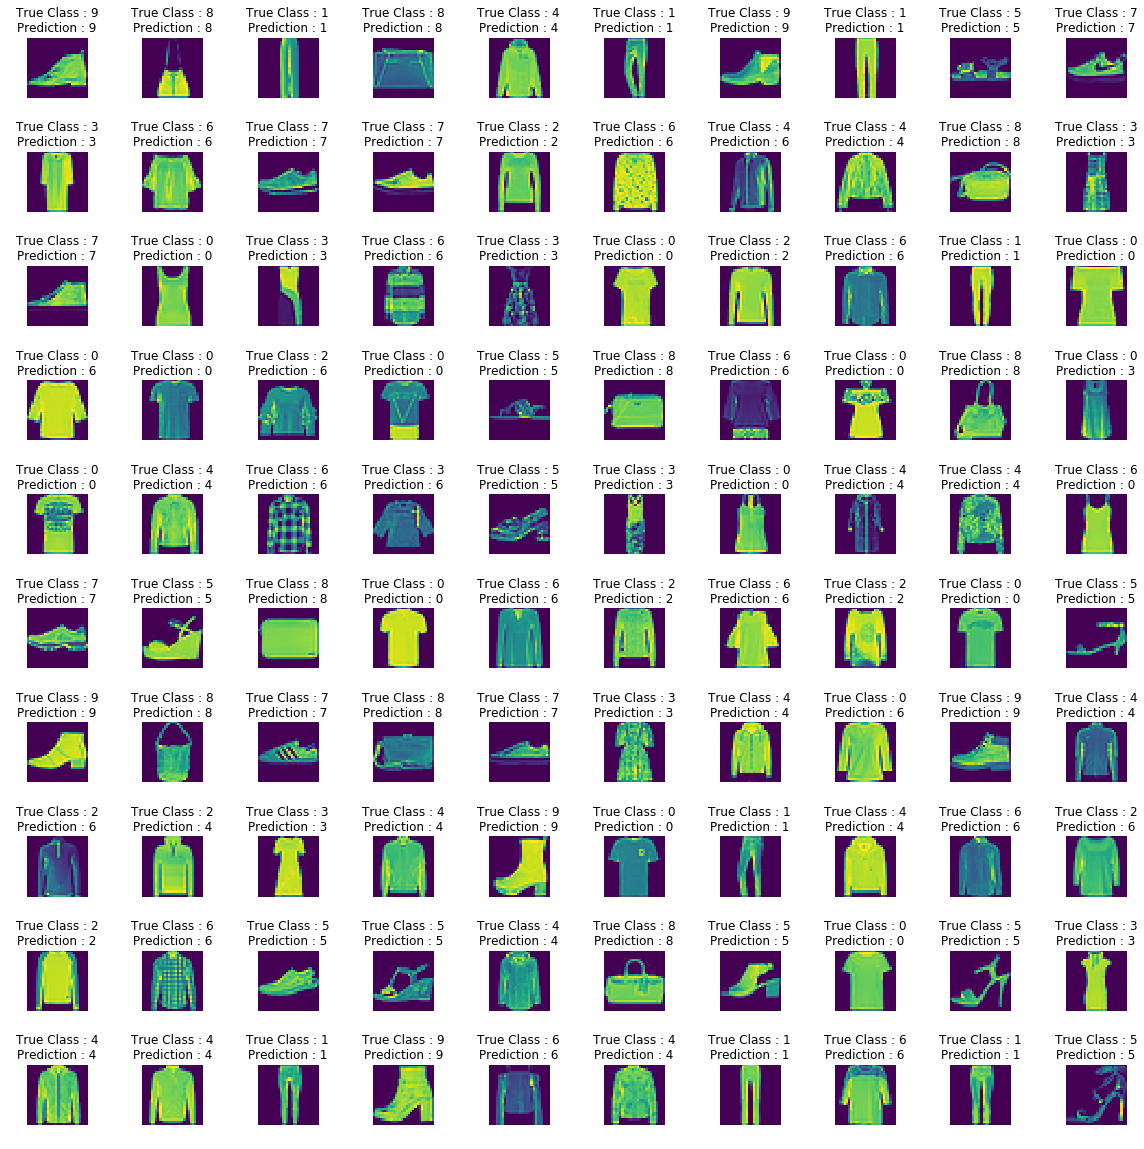

In [19]:
height = 10
width = 10

fig, axes = plt.subplots(nrows=width, ncols=height, figsize=(20,20))
axes = axes.ravel()
for i in range(0, height*width):
    index = np.random.randint(len(y_pred))
    axes[i].imshow(X_test[index].reshape((28,28)))
    axes[i].set_title("True Class : {:0.0f}\nPrediction : {:d}".format(y_test[index],y_pred[index]))
    axes[i].axis('off')
plt.subplots_adjust(hspace=0.9, wspace=0.5)

**Plot Confusin Matrix**

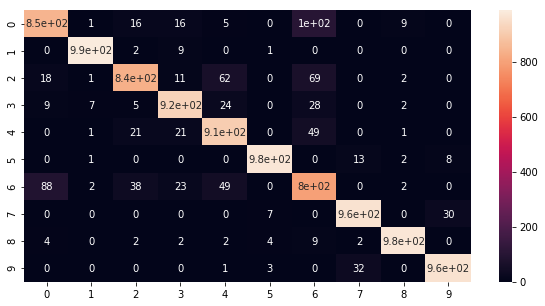

In [20]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,5))
sbn.heatmap(cm, annot=True)

**Classification Report**

In [21]:
num_classes = 10
class_names = ["class {}".format(i) for i in range(num_classes)]
cr = classification_report(y_test, y_pred, target_names=class_names)
print(cr)

              precision    recall  f1-score   support

     class 0       0.88      0.85      0.86      1000
     class 1       0.99      0.99      0.99      1000
     class 2       0.91      0.84      0.87      1000
     class 3       0.92      0.93      0.92      1000
     class 4       0.86      0.91      0.88      1000
     class 5       0.98      0.98      0.98      1000
     class 6       0.75      0.80      0.78      1000
     class 7       0.95      0.96      0.96      1000
     class 8       0.98      0.97      0.98      1000
     class 9       0.96      0.96      0.96      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

